# Create the dataset with the alignment of words and ELMo's vectors

In [1]:
import h5py
from IPython.display import clear_output
from random import shuffle
import matplotlib.patches as mpatches
from mixed_regression_functions import *

### Helping functions

In [2]:
import pickle

def save_data_with_pickle(relative_path, data):
    """ Save data using pickle (serialize) """

    with open(relative_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_data_with_pickle(relative_path):
    """ Load data using pickle (deserialize) """

    with open(relative_path, 'rb') as handle:
        return pickle.load(handle)

In [3]:
from sklearn.model_selection import train_test_split
def get_elmo_datasets(data, test_size):
    X = []
    Y_type = []
    Y_hyperbolic = []
    labels = []
    for key in data.keys():
        for word in data[key]:
            X.append(word)
            labels.append(key)
    
    Y = labels
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    
    labels_train = y_train
    labels_test = y_test
        
    return np.array(X_train), np.array(X_test), labels_train, labels_test


## Read sentences and split them in a list

In [4]:
lines = {}
with open('/datahdd/vmanuel/ELMo/Corpora/40k_dbpedia_sentences.txt', 'r') as inp:
    lines['40k'] = inp.readlines()
    lines['40k'] = [l.split() for l in lines['40k']]
    
liness = []
liness = lines['40k']
# liness.extend(lines['80k'])
len(liness)

40000

### Load vectors

In [5]:
PATH_TO_VECTORS = '/datahdd/vmanuel/ELMo/vectors/40k_elmo_layers.hdf5'
vectors = h5py.File(PATH_TO_VECTORS, 'r')
len(vectors)

40001

In [6]:
vectorss = {}
i = 0
for k,v in vectors.items():
    if k != 'sentence_to_index':
        vectorss[int(k)] = v
        i += 1
        if i % 1000 == 0:
            clear_output()
            print('{} lines'.format(i))


40000 lines


#### Little analysis

In [7]:
unique_words = set([s for sublist in liness for s in sublist])
len(unique_words)

175929

In [8]:
words_number = len([s for sublist in liness for s in sublist])
words_number

5842966

### Check the correspondance between sentences and their vectors (same position in the two lists)

In [9]:
len(liness[4000])

95

In [10]:
len(vectorss[4000][1])

95

### ELMo's embedding have 3 vectors for each occurrence of each word (because the architecture has 3 layer, as showed in the paper)
#### vectors has [40000 x 3 x nwords] which corresponds to: [sentence x layer_units x word_per_sentence]

### For each sentence we took layer 1 (experimentally even layer 2 was used and does not change the behaviour of the model) 
#### and Create a dictionary which has words as key and [vectors] as values

In [11]:
word_vectors = {}
prec = 0
for i, line in enumerate(liness):
    embeddings = vectorss[i][1]
    for word, vec in zip(line, embeddings):
#         if word in all_good_words:
        try:
            word_vectors[word].append(vec)
        except:
            word_vectors[word] = [vec]
    frac = int(round(i/len(liness), 3) * 100)
    if frac != prec:
        prec = frac
        clear_output()
        print('{}%'.format(frac))

100%


### Set the classes for the experiments 
#### Classes are organised as 'son-of', this division will be usefull with the test dataset

In [12]:
sons_of = {}

sons_of['Activity'] = ['Sport']
sons_of['Agent'] = ['FictionalCharacter']
sons_of['Organisation'] = ['Company', 
                           'SportsTeam']
sons_of['Thing'] = ['Award', 
                    'Colour',
                    'EthnicGroup', 
                    'Language',
                    'Plant', 
                    'Weapon']
sons_of['Place'] = ['ArchitecturalStructure', 
                    'Planet']
sons_of['Animal'] = ['Bird',
                     'Insect', 
                     'Mammal']
# sons_of['Person'] = ['Artist', 'Scientist'
#                     ,'Athlete', 'Writer'
#                     ]

In [13]:
types = ['dbo:' + s for sublist in sons_of.values() for s in sublist]

classes = [x.replace('dbo:', '') for x in types]

# types = ['dbo:Mammal'
#          , 'dbo:Planet'
#          , 'dbo:Company'
# #     , 'dbo:Broadcaster'
#          , 'dbo:City'
#          , 'dbo:Plant'
# #          , 'dbo:Conifer'
# #          , 'dbo:FloweringPlant'
#          , 'dbo:AnatomicalStructure'
# #          , 'dbo:Food'
# #          , 'dbo:Aircraft'
# #          , 'dbo:Automobile'
# #          ,'dbo:Animal'
# #          , 'dbo:Bird'
# #          , 'dbo:Fish'
# #          , 'dbo:Crustacean'
# #          , 'dbo:Software'
# #          , 'dbo:Politician'
#         ]

### get_from_class is a method defined in mixed_regression_functions.py, which contains usefull handmade functions
#### this method returns a list with the entities in dbPedia which have as type the types fixed above

In [14]:
words = []
import re

pat = re.compile('[A-Z][a-z]*[A-Z][a-z]*')
midpat = re.compile('[A-Z][a-z]*')

for i, t in enumerate(types):
    w = get_from_class(t)
    if pat.findall(t):
        to_append = midpat.findall(t)[0] + '_' + midpat.findall(t)[1]
    else:
        to_append = t.replace('dbo:', '') 
    print(to_append)
    w.append(to_append)
    words.append(w) 
    clear_output()
    print('{}%'.format(int(round(i/len(types), 2)) * 100))

100%


### Ariety of each class, in the SPARQL query there was a cap at 10.000 entities
#### For each class we will have entities of this class and the name of the class (e.g. the word 'Sport' for 'dbo:Sport')

In [15]:
{k:len(v) for k,v in zip(types, words)}

{'dbo:Sport': 1819,
 'dbo:FictionalCharacter': 10001,
 'dbo:Company': 10001,
 'dbo:SportsTeam': 10001,
 'dbo:Award': 10001,
 'dbo:Colour': 862,
 'dbo:EthnicGroup': 9452,
 'dbo:Language': 10001,
 'dbo:Plant': 10001,
 'dbo:Weapon': 10001,
 'dbo:ArchitecturalStructure': 10001,
 'dbo:Planet': 4785,
 'dbo:Bird': 10001,
 'dbo:Insect': 10001,
 'dbo:Mammal': 10001}

### Check which retrieved word are present in the corpus

In [16]:
good_words = [[] for i in range(len(words))]
i = 0
j = 0
for type_index, type_words in enumerate(words):
    for word in type_words:
        if word.lower() in unique_words:
            good_words[type_index].append(word.lower())
        else:
            i += 1

print('{} found on {}'.format(sum([len(x) for x in words]) - i + j, 
                              sum([len(x) for x in words])))

all_good_words = [item for sublist in good_words for item in sublist] 

dataset = {}
for t, type_words in zip(types, good_words):
    dataset.update({t.replace('dbo:', '') : [m for m in type_words]})

for k, w in zip(dataset.keys(), dataset):
    print('{} {}'.format(len(dataset[k]), k))   

4351 found on 126929
109 Sport
829 FictionalCharacter
924 Company
20 SportsTeam
23 Award
38 Colour
469 EthnicGroup
189 Language
862 Plant
125 Weapon
102 ArchitecturalStructure
54 Planet
143 Bird
217 Insect
247 Mammal


## Update dataset with composite words

### go in composite_words.ipynb to find the retrieving of composite words (word phrases)

In [17]:
COMPOSITE_WORD_INDEX_PATH = '/datahdd/vmanuel/datasets/composite_words_index'
comp_word_indexes = load_data_with_pickle(COMPOSITE_WORD_INDEX_PATH)

### append found word phrases to other words

In [18]:
updated = []
        
for k, v in comp_word_indexes.items():
    dataset[v[0]].append(k)
    
for k, w in zip(dataset.keys(), dataset):
    print('{} {}'.format(len(dataset[k]), k))

250 Sport
1347 FictionalCharacter
1820 Company
211 SportsTeam
143 Award
55 Colour
638 EthnicGroup
437 Language
1119 Plant
223 Weapon
513 ArchitecturalStructure
76 Planet
215 Bird
259 Insect
361 Mammal


In [19]:
save_data_with_pickle('/datahdd/vmanuel/datasets/word_and_composite_dataset', dataset)

In [20]:
dataset

{'Sport': ['basketball',
  'cricket',
  'tennis',
  'baseball',
  'volleyball',
  'golf',
  'handball',
  'fishing',
  'wrestling',
  'commerce',
  'softball',
  'gymnastics',
  'hurling',
  'lacrosse',
  'futsal',
  'archery',
  'badminton',
  'surfing',
  'diving',
  'bandy',
  'pedagogy',
  'netball',
  'curling',
  'snowboarding',
  'sumo',
  'recreation',
  'geodesy',
  'snooker',
  'polo',
  'incest',
  'skateboarding',
  'genomics',
  'camping',
  'triathlon',
  'hobby',
  'bobsleigh',
  'windsurfing',
  'dredging',
  'biathlon',
  'canoeing',
  'rodeo',
  'woodworking',
  'advocacy',
  'bowls',
  'climbing',
  'luge',
  'racewalking',
  'apologetics',
  'dressage',
  'cockfight',
  'bmx',
  'powerlifting',
  'darts',
  'camogie',
  'folkloristics',
  'gliding',
  'paragliding',
  'kitesurfing',
  'boating',
  'shinty',
  'downhill',
  'kabaddi',
  'steeplechase',
  'eventing',
  'croquet',
  'floorball',
  'quidditch',
  'racquetball',
  'repentance',
  'arnis',
  'rounders',
 

## Retrieve Minimal Type

### go in minimal.ipynb to see how minimal type is retrieved
#### this is usefull to avoid multilabeling, because same word can be polysemic (think about 'Jaguar' which is a car, a animal and a company, three entities with the same name, in our work we avoid these cases by maintaining only the minimal type 

In [21]:
dataset = load_data_with_pickle('/datahdd/vmanuel/datasets/minimal_type_dataset')

#### Some differences with respect to the previous summary

In [22]:
{k: len(v) for k,v in dataset.items()}

{'Sport': 250,
 'FictionalCharacter': 1331,
 'Company': 1814,
 'SportsTeam': 208,
 'Award': 143,
 'Colour': 54,
 'EthnicGroup': 595,
 'Language': 427,
 'Plant': 1109,
 'Weapon': 222,
 'ArchitecturalStructure': 513,
 'Planet': 75,
 'Bird': 212,
 'Insect': 218,
 'Mammal': 356}

## Create Dataset

### Partition in train test and val (80-10-10)
#### The partition is made on words because we want to check the ability to retrieve the concept based only on similarity between words embedding

In [23]:
train, test, labels_train, labels_test = get_elmo_datasets(dataset, 0.2)

datatest = {c:[] for c in classes}

for y, w in zip(labels_test, test):
    datatest[y].append(w)
    
val, test, labels_val, labels_test = get_elmo_datasets(datatest, 0.5)

In [24]:
len(train)

6021

In [25]:
len(test)

753

In [26]:
len(val)

753

### Retrieve vectors from words, for composite words we use the euclidean mean (euristics)

#### Train

In [27]:
X_train = []
Y_train = []
word_train = []

tot = len(train)
prev = 0
ks = comp_word_indexes.keys()
for j, (word, label) in enumerate(zip(train, labels_train)):
    if word in ks:
        vecs = []
        for v in comp_word_indexes[word][1:]:
            vecs.append((vectorss[v[1]][1][v[0][0]] + vectorss[v[1]][1][v[0][1]]) / 2)
    else:
        vecs = word_vectors[word]
    for i, v in enumerate(vecs):
        X_train.append(v)
        Y_train.append(label)
        word_train.append('{}_{}'.format(word,i))
    
    perc = int(round(j / tot, 2) * 100)
    if perc != prev:
        clear_output()
        prev = perc
        print('{}%'.format(prev))

#### Test

In [28]:
X_test = []
Y_test = []
word_test = []

tot = len(test)
prev = 0
ks = comp_word_indexes.keys()

for j, (word, label) in enumerate(zip(test, labels_test)):
    if word in comp_word_indexes.keys():
        vecs = []
        for v in comp_word_indexes[word][1:]:
            vecs.append((vectorss[v[1]][1][v[0][0]] + vectorss[v[1]][1][v[0][1]]) / 2)
    else:
        vecs = word_vectors[word]
#     vecs = word_vectors_2[word]
    for i, v in enumerate(vecs):
        X_test.append(v)
        Y_test.append(label)
        word_test.append('{}_{}'.format(word,i))
        
    perc = int(round(j / tot, 2) * 100)
    if perc != prev:
        clear_output()
        prev = perc
        print('{}%'.format(prev))

100%


#### Val

In [29]:
X_val = []
Y_val = []
word_val = []

tot = len(val)
prev = 0
ks = comp_word_indexes.keys()

for j, (word, label) in enumerate(zip(val, labels_val)):
    if word in comp_word_indexes.keys():
        vecs = []
        for v in comp_word_indexes[word][1:]:
            vecs.append((vectorss[v[1]][1][v[0][0]] + vectorss[v[1]][1][v[0][1]]) / 2)
    else:
        vecs = word_vectors[word]
#     vecs = word_vectors_2[word]
    for i, v in enumerate(vecs):
        X_val.append(v)
        Y_val.append(label)
        word_val.append('{}_{}'.format(word,i))
        
    perc = int(round(j / tot, 2) * 100)
    if perc != prev:
        clear_output()
        prev = perc
        print('{}%'.format(prev))

100%


### Shuffle all datasets because classes are ordered now

In [30]:
A = [[x, y, w] for x,y,w in zip(X_train, Y_train, word_train)]
shuffle(A)
X_train = [x[0] for x in A]
Y_train = [x[1] for x in A]
word_train = [x[2] for x in A]

A = [[x, y, w] for x,y,w in zip(X_test, Y_test, word_test)]
shuffle(A)
X_test = [x[0] for x in A]
Y_test = [x[1] for x in A]
word_test = [x[2] for x in A]


A = [[x, y, w] for x,y,w in zip(X_val, Y_val, word_val)]
shuffle(A)
X_val = [x[0] for x in A]
Y_val = [x[1] for x in A]
word_val = [x[2] for x in A]


### Summary of the datasets

In [33]:
from collections import Counter
Tr = Counter(Y_train).most_common()
Te = Counter(Y_test).most_common()
Va = Counter(Y_val).most_common()

print('{:^30}|{:^30}|{:^30}'.format('Train','Val', 'Test'))
print('{:-^30}|{:-^30}|{:-^30}'.format('', '', ''))

for x, y, z in zip(Tr, Va, Te):
    print('{:^25}{:^5}|{:^25}{:^5}|{:^25}{:^5}'.format(x[0], x[1], y[0], y[1], z[0], z[1]))

            Train             |             Val              |             Test             
------------------------------|------------------------------|------------------------------
         Company         24754|          Award          2205 |          Plant          4105 
        Language         17998|         Colour          2003 |         Company         3425 
          Plant          8361 |         Company         1577 |        Language         1025 
         Mammal          7135 |        Language         1526 |   FictionalCharacter     997 
   FictionalCharacter    6378 |         Mammal          1499 |       EthnicGroup        962 
 ArchitecturalStructure  4722 |       EthnicGroup        878 |          Award           434 
       EthnicGroup       4419 |          Plant           867 |         Weapon           415 
         Colour          4179 |         Weapon           713 |          Sport           216 
          Sport          3459 |   FictionalCharacter     663 | Archite

In [36]:
for c in classes:
    print('{} : {}'.format(c, dict(Tr)[c] + dict(Te)[c] + dict(Va)[c]))

Sport : 4203
FictionalCharacter : 8038
Company : 29756
SportsTeam : 884
Award : 4305
Colour : 6210
EthnicGroup : 6259
Language : 20549
Plant : 13333
Weapon : 2437
ArchitecturalStructure : 4979
Planet : 3932
Bird : 1396
Insect : 901
Mammal : 8798


## Let's see how are distributed our data!!!

(-9.132211685180664, 9.315555572509766)

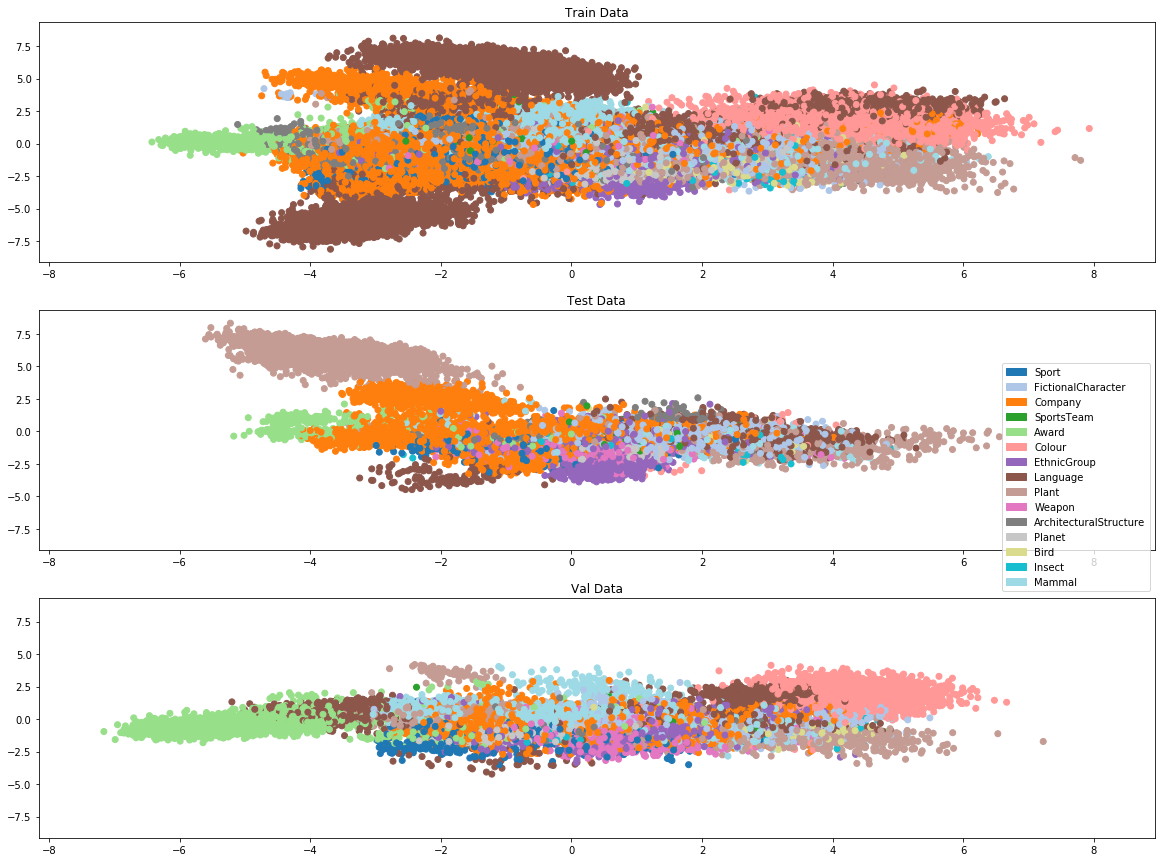

In [43]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm

colors = cm.tab20(np.linspace(0, 1, len(classes)))
color_map = {cla: col for cla,col in zip(classes, colors)}

patchList = []

for key in classes:
    data_key = mpatches.Patch(color=color_map[key], label=key)
    patchList.append(data_key)


train_colors = [color_map[k] for k in Y_train]
test_colors = [color_map[k] for k in Y_test]
val_colors = [color_map[k] for k in Y_val]

sklearn_pca = PCA(n_components=2)
        
sklearn_pca.fit(np.concatenate((X_train, X_test, X_val), axis = 0))

data = sklearn_pca.transform(X_train)
X_plot = [x[0] for x in data]
Y_plot = [x[1] for x in data]

data_test = sklearn_pca.transform(X_test)
X_test_plot = [x[0] for x in data_test]
Y_test_plot = [x[1] for x in data_test]

data_test = sklearn_pca.transform(X_val)
X_val_plot = [x[0] for x in data_test]
Y_val_plot = [x[1] for x in data_test]


X_min = min(np.append(np.append(X_plot, X_test_plot), X_val_plot))
X_max = max(np.append(np.append(X_plot, X_test_plot), X_val_plot))
Y_min = min(np.append(np.append(Y_plot, Y_test_plot), Y_val_plot))
Y_max = max(np.append(np.append(Y_plot, Y_test_plot), Y_val_plot))

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (20, 15))

ax1.scatter(X_plot, Y_plot, c = train_colors)
ax1.set_title('Train Data')

ax1.set_xlim(X_min - 1, X_max + 1)
ax1.set_ylim(Y_min - 1, Y_max + 1)

ax2.scatter(X_test_plot, Y_test_plot, c = test_colors)
ax2.set_title('Test Data')    

plt.legend(handles=patchList, bbox_to_anchor=(1, 2))

ax2.set_xlim(X_min - 1, X_max + 1)
ax2.set_ylim(Y_min - 1, Y_max + 1)

ax3.scatter(X_val_plot, Y_val_plot, c = val_colors)
ax3.set_title('Val Data')    

ax3.set_xlim(X_min - 1, X_max + 1)
ax3.set_ylim(Y_min - 1, Y_max + 1)

In [64]:
PATH_TO_DATASET = '/datahdd/vmanuel/datasets/elmo_layer_1/17_classes/'

save_data_with_pickle(PATH_TO_DATASET + 'X_train', np.array(X_train))
save_data_with_pickle(PATH_TO_DATASET + 'Y_train', np.array(Y_train))
save_data_with_pickle(PATH_TO_DATASET + 'word_train', np.array(word_train))
save_data_with_pickle(PATH_TO_DATASET + 'Y_test', np.array(Y_test))
save_data_with_pickle(PATH_TO_DATASET + 'X_test', np.array(X_test))
save_data_with_pickle(PATH_TO_DATASET + 'word_test', np.array(word_test))
save_data_with_pickle(PATH_TO_DATASET + 'Y_val', np.array(Y_val))
save_data_with_pickle(PATH_TO_DATASET + 'X_val', np.array(X_val))
save_data_with_pickle(PATH_TO_DATASET + 'word_val', np.array(word_val))

## Retrieve Invention Vectors

In [78]:
words_to_invent = load_data_with_pickle('/datahdd/vmanuel/datasets/words_to_invent')
classes_to_invent = load_data_with_pickle('/datahdd/vmanuel/datasets/classes_to_invent')

In [79]:
good_invention_words = [[] for i in range(len(words_to_invent))]
i = 0
j = 0
for type_index, type_words in enumerate(words_to_invent):
    for word in type_words:
        try:
            word_vectors[word.lower()]
            good_invention_words[type_index].append(word.lower())
        except:
            i += 1

print('{} found on {}'.format(sum([len(x) for x in words_to_invent]) - i + j, sum([len(x) for x in words_to_invent])))

all_words = [item for sublist in good_invention_words for item in sublist] 

invention_dataset = {}
for t, type_words in zip(classes_to_invent, good_invention_words):
    invention_dataset.update({t.replace('dbo:', '') : [m for m in type_words]})

for k, w in zip(invention_dataset.keys(), invention_dataset):
    print('{} {}'.format(len(invention_dataset[k]), k))   

493 found on 62149
8 Currency
23 Amphibian
43 Crustacean
11 SportsLeague
56 Mollusca
64 Game
37 GovernmentAgency
56 Reptile
10 EducationalInstitution
185 Fish


In [80]:
k_to_del = []
print(len(invention_dataset))
for k,v in zip(invention_dataset.keys(), invention_dataset.values()):
    if v == []:
        k_to_del.append(k)
for k in k_to_del:
    del invention_dataset[k]
print(len(invention_dataset))


10
10


In [81]:
import numpy as np
invention_train, invention_test, labels_invention_train, labels_invention_test = get_elmo_datasets(invention_dataset, 0.1)

X_invention_train = []
Y_invention_train = []
word_invention_train = []

for word, label in zip(invention_train, labels_invention_train):
    vecs = word_vectors[word]
    for i, v in enumerate(vecs):
        X_invention_train.append(v)
        Y_invention_train.append(label)
        word_invention_train.append('{}_{}'.format(word,i))
        
X_invention_test = []
Y_invention_test = []
word_invention_test = []

for word, label in zip(invention_test, labels_invention_test):
    vecs = word_vectors[word]
    for i, v in enumerate(vecs):
        X_invention_test.append(v)
        Y_invention_test.append(label)
        word_invention_test.append('{}_{}'.format(word,i))
                          

A = [[x, y, w] for x,y,w in zip(X_invention_train, Y_invention_train, word_invention_train)]
shuffle(A)
X_invention_train = [x[0] for x in A]
Y_invention_train = [x[1] for x in A]
word_invention_train = [x[2] for x in A]

A = [[x, y, w] for x,y,w in zip(X_invention_test, Y_invention_test, word_invention_test)]
shuffle(A)
X_invention_test = [x[0] for x in A]
Y_invention_test = [x[1] for x in A]
word_invention_test = [x[2] for x in A]
X_invention_train.extend(X_invention_test)
Y_invention_train.extend(Y_invention_test)
word_invention_train.extend(word_invention_test)


In [213]:
save_data_with_pickle('/datahdd/vmanuel/datasets/invention_datasets/16_classes/X_invention_1', np.array(X_invention_train))
save_data_with_pickle('/datahdd/vmanuel/datasets/invention_datasets/16_classes/Y_invention_1', np.array(Y_invention_train))
save_data_with_pickle('/datahdd/vmanuel/datasets/invention_datasets/16_classes/word_invention_1', np.array(word_invention_train))


## Extract Dataset for Quality Evaluation

In [18]:
quality_words = ['alcohol', 'beaver', 'jpeg', 'algae']

In [19]:
for w in quality_words:
    print('{} : {}'.format(w, len(word_vectors[w])))

alchemy : 17
beaver : 194
jpeg : 29
algae : 112


In [20]:
quality_vectors = []
quality_labels = []
for w in quality_words:
    for v in word_vectors[w]:
        quality_vectors.append(v)
        quality_labels.append(w)

In [21]:
save_data_with_pickle('/datahdd/vmanuel/datasets/invention_datasets/17_classes/quality_vectors', np.array(quality_vectors))
save_data_with_pickle('/datahdd/vmanuel/datasets/invention_datasets/17_classes/quality_labels', quality_labels)